Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import RepeatedKFold
import sklearn.metrics as sm

Reading data

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
data = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


SalePrice is our target varieble

Let's look at our correlation

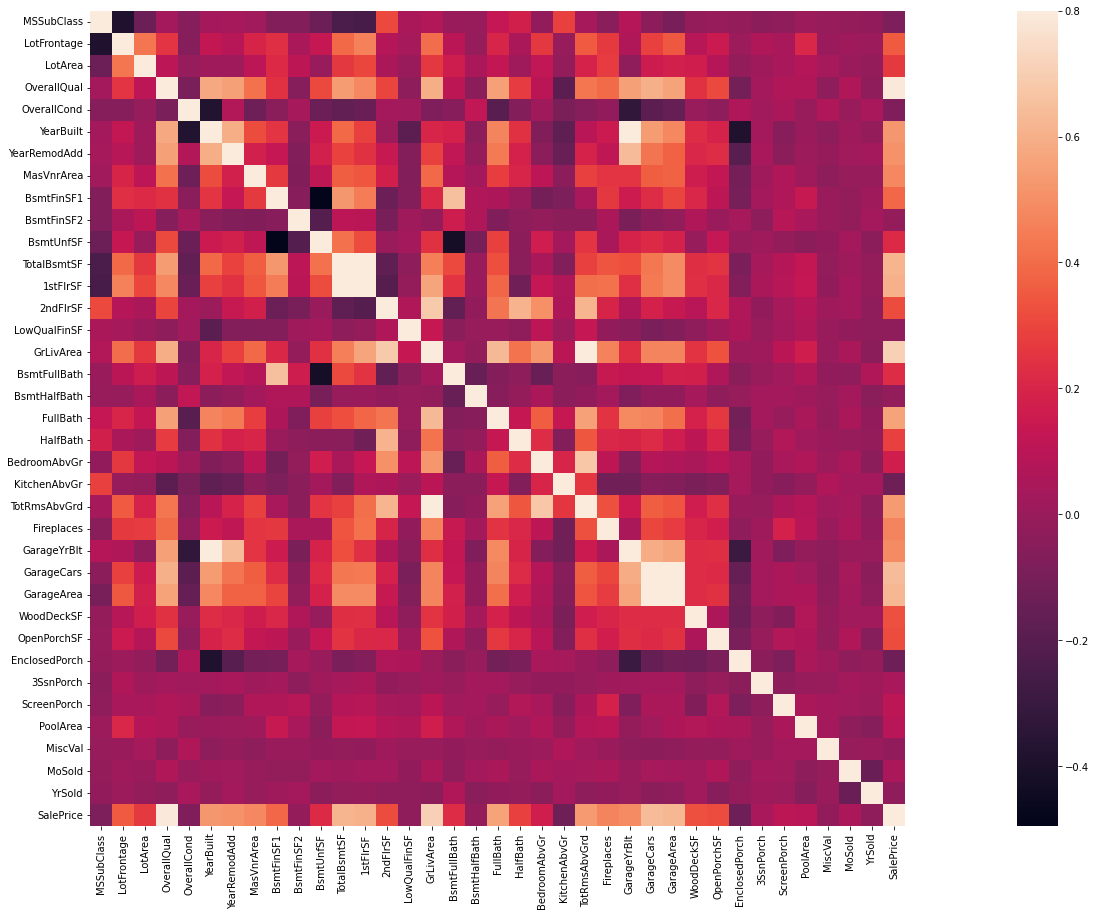

In [3]:
corrmat = data.corr() #correlation for all values
f, ax = plt.subplots(figsize=(40, 15))
sns.heatmap(corrmat, vmax=.8, square=True);

As we can see that (TotalBsmtSF and 1stFirSf), (GarageYrBlt and YearBuilt) and also (GarageCars and GarageArea) are strongly correlated, so we can use only one column of the pairs for our analysis
About SalePrice it is strongly correlated with OverallQual, GrLivArea, TotalBsmtSF and GarageCars
But let's look on our the strrongest correlations for our target variable

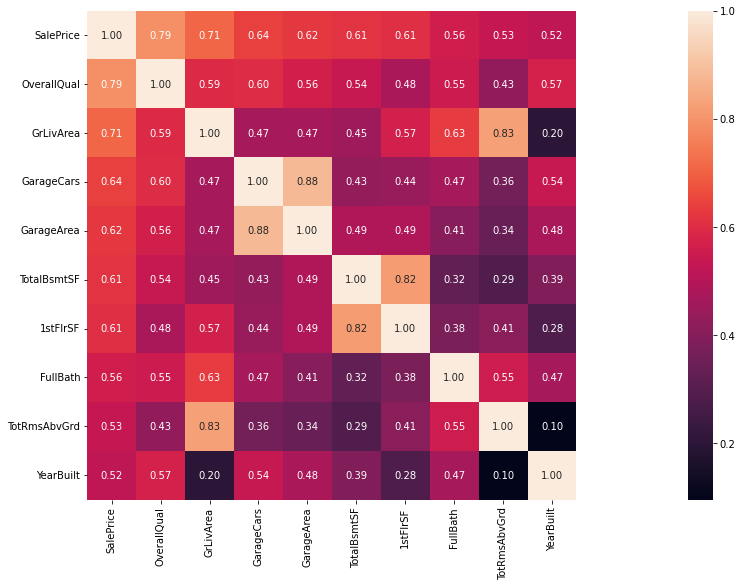

In [4]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
f, ax = plt.subplots(figsize=(40, 9))
cm = np.corrcoef(data[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

So let's make some conclusions. OveralQual and GrLivArea are the most correlated with SalePrice
After this we see GarageCars and GargeArea, but they have also strong correlation with each other, so I offer use only GarageCars
The same situation is for TotalBsmtSF and 1stFirSf. We will use TotalBsmtSF.
TotRmsAbvGrd has strong corr with GrLivArea, so we will ignore this variable.
And we can use also FullBath and YearBuilt

Missing values

Firstly we need rewrite our text-values in numeric

In [5]:
all_data = pd.concat((data.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [6]:
mis_val = pd.DataFrame({"mis values": all_data.isnull().sum(),"procent of mis values": 100*all_data.isnull().sum()/len(data)})
mis_val[mis_val['mis values']>0]

,mis values,procent of mis values
MSZoning,4,0.273973
LotFrontage,486,33.287671
Alley,2721,186.369863
Utilities,2,0.136986
Exterior1st,1,0.068493
Exterior2nd,1,0.068493
MasVnrType,24,1.643836
MasVnrArea,23,1.575342
BsmtQual,81,5.547945
BsmtCond,82,5.616438


If more than 15% of data is missing values we need to delete this column

In [7]:
mis_cols = list(mis_val[mis_val['procent of mis values']>15].index)
new_data = all_data.drop(mis_cols, axis=1)
mis_val = pd.DataFrame({"mis values": new_data.isnull().sum(),"procent of mis values": 100*new_data.isnull().sum()/len(new_data)})
mis_val[mis_val['mis values']>0]

,mis values,procent of mis values
MSZoning,4,0.137033
Utilities,2,0.068517
Exterior1st,1,0.034258
Exterior2nd,1,0.034258
MasVnrType,24,0.822199
MasVnrArea,23,0.787941
BsmtQual,81,2.774923
BsmtCond,82,2.809181
BsmtExposure,82,2.809181
BsmtFinType1,79,2.706406


What about another variables.
* About variables like Garage..., we can delete GarageYrBlt, GarageType, GarageFinish, GarageQual, GarageCond because we have another variables like the GarageCars and here we just replace 1 missed value with mean
* BSMT... I leave the vars that have only 1 missing val and another delete
* MasVnrArea and MasVnrType I also want to delete it, because it hasn't so strong correlation with target variable and it has correlation with important for us variable
* BsmtHalfBath I delete because it has no correlation with target variable
* All another values I will replace with mean values.

In [8]:
mis_cols_del = ['MasVnrType', 'GarageYrBlt', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType2', 'BsmtFinType1', 'BsmtExposure', 'BsmtCond', 'BsmtQual']
new_data = new_data.drop(mis_cols_del, axis=1)
mis_val = pd.DataFrame({"mis values": new_data.isnull().sum(),"procent of mis values": 100*new_data.isnull().sum()/len(new_data)})
mis_val[mis_val['mis values']>0]

,mis values,procent of mis values
MSZoning,4,0.137033
Utilities,2,0.068517
Exterior1st,1,0.034258
Exterior2nd,1,0.034258
MasVnrArea,23,0.787941
BsmtFinSF1,1,0.034258
BsmtFinSF2,1,0.034258
BsmtUnfSF,1,0.034258
TotalBsmtSF,1,0.034258
Electrical,1,0.034258


Okay, this all values I will replace with mean values. But firstly, let's change our objects variable in numerical ones

In [9]:
columns_object = list(new_data.select_dtypes(include=[object]).columns)
for col in columns_object:
    dict_val = dict()
    for (ind, val) in enumerate(list(new_data[col].unique())):
        if pd.isna(val):
            dict_val[val]=val
        else:
            dict_val[val]=ind
    new_data[col].replace(dict_val, inplace=True)

In [10]:
missed_cols = list(mis_val[mis_val['mis values']>0].index)
for col in missed_cols:
    if col in columns_object:
        new_data[col]=new_data.groupby(['OverallQual'])[col].apply(lambda x: x.fillna(x.mode().iloc[0]))
    else:
        new_data[col] = new_data[col].fillna(new_data.groupby(['OverallQual', 'YearBuilt'])[col].transform('mean'))

New columns

In [11]:
new_data['garage'] = [1 if i>0 else 0 for i in new_data['GarageArea']]
new_data['pool'] = [1 if i>0 else 0 for i in new_data['PoolArea']]
new_data.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,garage,pool
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,0.0,8450,0,0,0,0.0,0,0,0,0,0,0,0,7,5,2003,2003,0,0,0.0,0.0,196.0,0,0,0,706.0,0.0,150.0,856.0,0,0,0,0.0,856,854,0,1710,1.0,0.0,2,1,3,1,0.0,8,0.0,0,2.0,548.0,0,0,61,0,0,0,0,0,2,2008,0.0,0,1,0
2,20,0.0,9600,0,0,0,0.0,1,0,1,1,0,0,1,6,8,1976,1976,0,0,1.0,1.0,0.0,1,0,1,978.0,0.0,284.0,1262.0,0,0,0,0.0,1262,0,0,1262,0.0,1.0,2,0,3,1,1.0,6,0.0,1,2.0,460.0,0,298,0,0,0,0,0,0,5,2007,0.0,0,1,0
3,60,0.0,11250,0,1,0,0.0,0,0,0,0,0,0,0,7,5,2001,2002,0,0,0.0,0.0,162.0,0,0,0,486.0,0.0,434.0,920.0,0,0,0,0.0,920,866,0,1786,1.0,0.0,2,1,3,1,0.0,6,0.0,1,2.0,608.0,0,0,42,0,0,0,0,0,9,2008,0.0,0,1,0
4,70,0.0,9550,0,1,0,0.0,2,0,2,0,0,0,0,7,5,1915,1970,0,0,2.0,2.0,0.0,1,0,2,216.0,0.0,540.0,756.0,0,1,0,0.0,961,756,0,1717,1.0,0.0,1,0,3,1,0.0,7,0.0,1,3.0,642.0,0,0,35,272,0,0,0,0,2,2006,0.0,1,1,0
5,60,0.0,14260,0,1,0,0.0,1,0,3,0,0,0,0,8,5,2000,2000,0,0,0.0,0.0,350.0,0,0,0,655.0,0.0,490.0,1145.0,0,0,0,0.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,0.0,9,0.0,1,3.0,836.0,0,192,84,0,0,0,0,0,12,2008,0.0,0,1,0


Outliers

In [12]:
data = new_data.iloc[:len(data),:].join(data[['SalePrice']])
test = new_data.iloc[len(data):,:]
data.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,garage,pool,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,0.0,8450,0,0,0,0.0,0,0,0,0,0,0,0,7,5,2003,2003,0,0,0.0,0.0,196.0,0,0,0,706.0,0.0,150.0,856.0,0,0,0,0.0,856,854,0,1710,1.0,0.0,2,1,3,1,0.0,8,0.0,0,2.0,548.0,0,0,61,0,0,0,0,0,2,2008,0.0,0,1,0,208500
2,20,0.0,9600,0,0,0,0.0,1,0,1,1,0,0,1,6,8,1976,1976,0,0,1.0,1.0,0.0,1,0,1,978.0,0.0,284.0,1262.0,0,0,0,0.0,1262,0,0,1262,0.0,1.0,2,0,3,1,1.0,6,0.0,1,2.0,460.0,0,298,0,0,0,0,0,0,5,2007,0.0,0,1,0,181500
3,60,0.0,11250,0,1,0,0.0,0,0,0,0,0,0,0,7,5,2001,2002,0,0,0.0,0.0,162.0,0,0,0,486.0,0.0,434.0,920.0,0,0,0,0.0,920,866,0,1786,1.0,0.0,2,1,3,1,0.0,6,0.0,1,2.0,608.0,0,0,42,0,0,0,0,0,9,2008,0.0,0,1,0,223500
4,70,0.0,9550,0,1,0,0.0,2,0,2,0,0,0,0,7,5,1915,1970,0,0,2.0,2.0,0.0,1,0,2,216.0,0.0,540.0,756.0,0,1,0,0.0,961,756,0,1717,1.0,0.0,1,0,3,1,0.0,7,0.0,1,3.0,642.0,0,0,35,272,0,0,0,0,2,2006,0.0,1,1,0,140000
5,60,0.0,14260,0,1,0,0.0,1,0,3,0,0,0,0,8,5,2000,2000,0,0,0.0,0.0,350.0,0,0,0,655.0,0.0,490.0,1145.0,0,0,0,0.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,0.0,9,0.0,1,3.0,836.0,0,192,84,0,0,0,0,0,12,2008,0.0,0,1,0,250000


So firstly let's look at our target value

<AxesSubplot:xlabel='SalePrice'>

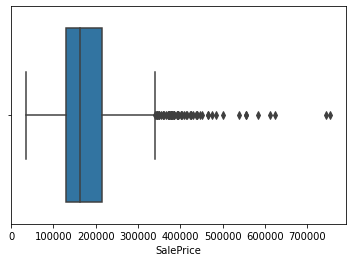

In [13]:
sns.boxplot(x=data['SalePrice'])

let's look at z-score

In [14]:
z = np.abs(stats.zscore(data['SalePrice']))
outlier_list = [z[i] for i in list(np.where((z > 3) | (z<-3)))]
sorted(outlier_list)

[Id
 58      0.196169
 178     0.106040
 185     0.678977
 349     0.338993
 389     0.126913
 440     0.893042
 473     0.414545
 496     1.838704
 527     0.616017
 591     0.062693
 664     0.546761
 691     0.502689
 769     0.452253
 798     0.893042
 803     0.101729
 898     0.478097
 1046    0.520318
 1142    0.208761
 1169    0.680962
 1182    2.664207
 1243    0.137520
 1373    1.175829
 Name: SalePrice, dtype: float64]

So we have several values that are far from zero, but we need to pay attention at two values that greater than 7. 
We will consider the values like normal

Now let's look at our important values

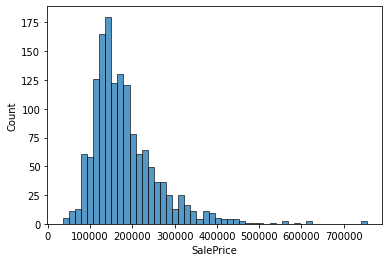

In [15]:
sns.histplot(data['SalePrice'], bins=50)
ax.set_xlabel('')
ax.set_title('SalePrice')
plt.show()

So our target is right-skewed, so it's better to use log transformation

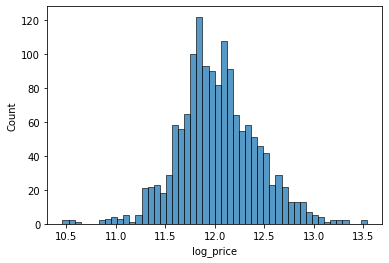

In [16]:
old_sale = data['SalePrice']
data['log_price'] = np.log(data['SalePrice'])
sns.histplot(data['log_price'], bins=50)
ax.set_xlabel('')
ax.set_title('log_price')
plt.show()

Much better, but what about other features

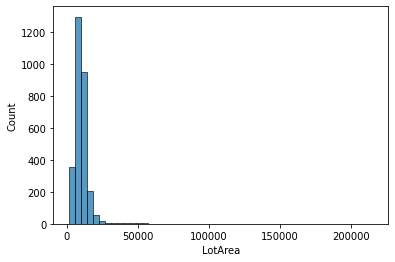

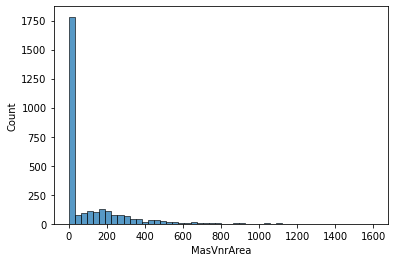

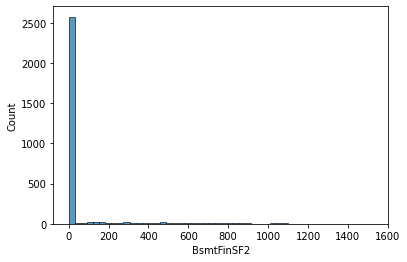

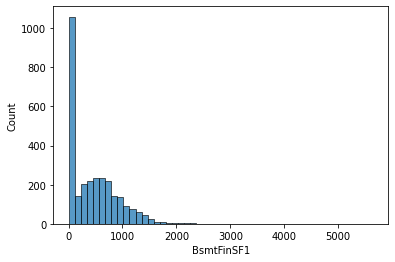

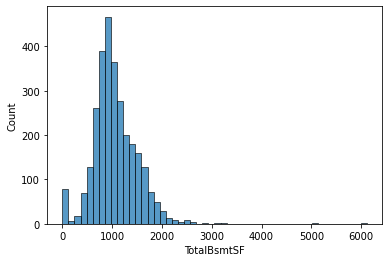

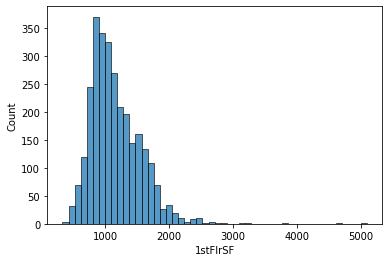

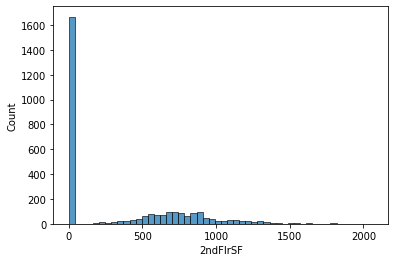

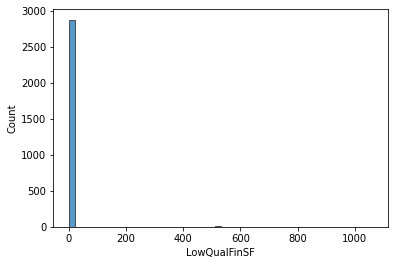

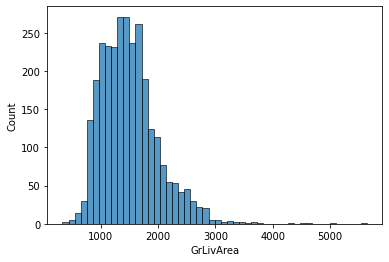

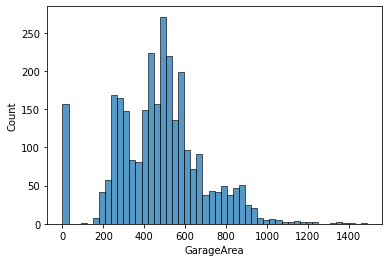

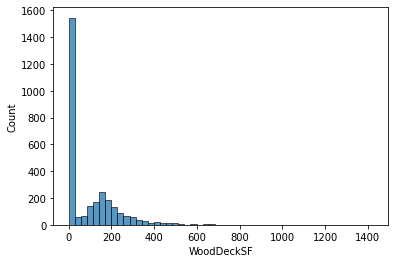

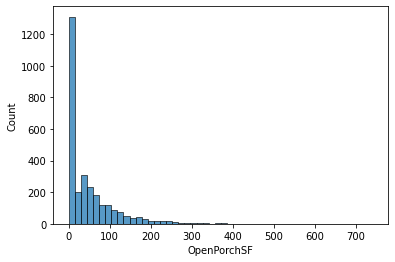

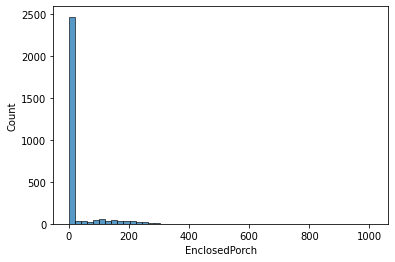

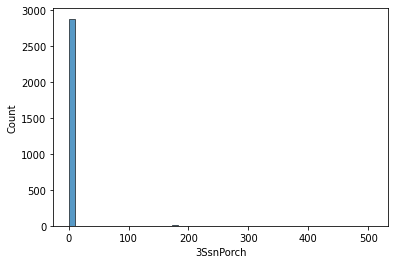

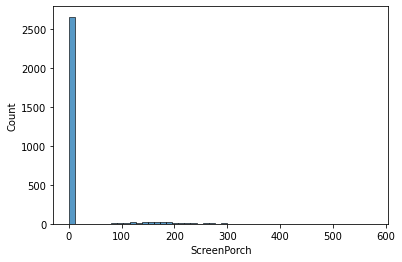

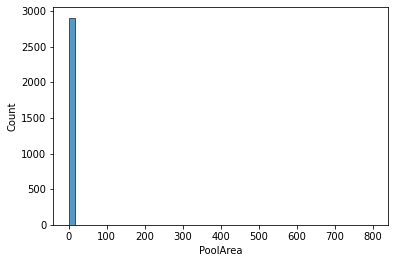

In [17]:
continuous_val = ['LotArea', 'MasVnrArea', 'BsmtFinSF2','BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']
for i in continuous_val:
    if i in list(new_data.columns):
        sns.histplot(new_data[i], bins=50)
        ax.set_xlabel('')
        ax.set_title('histogram of feature: ' + str(i))
        plt.show()

Most of continuous data also rig-skewed, so I'll use log transformation

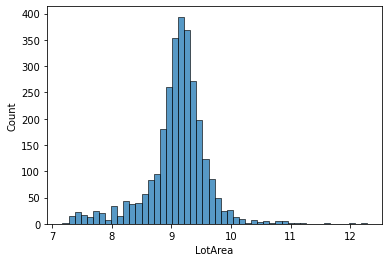

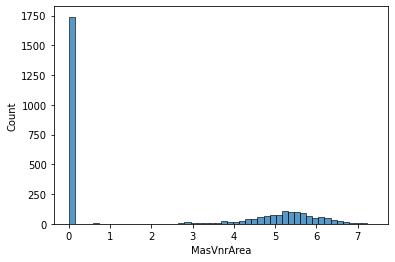

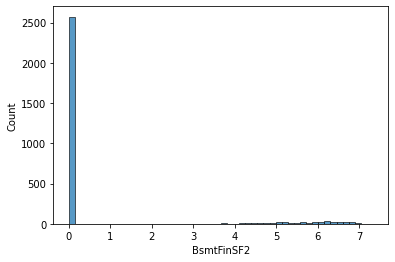

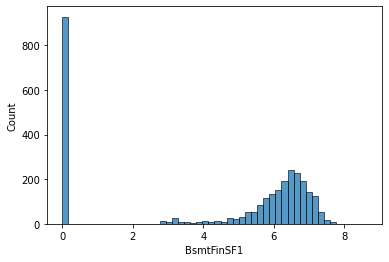

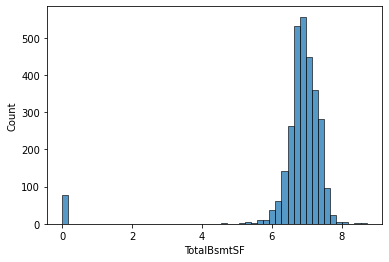

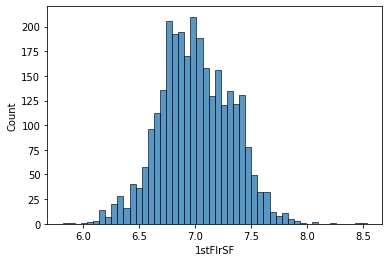

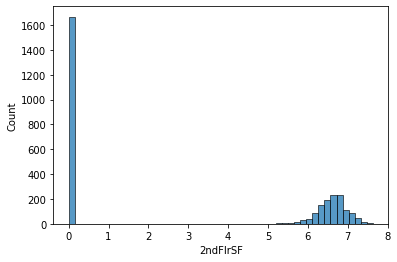

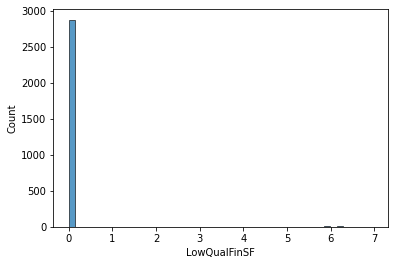

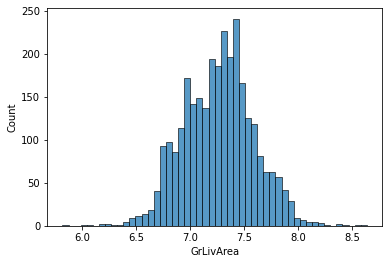

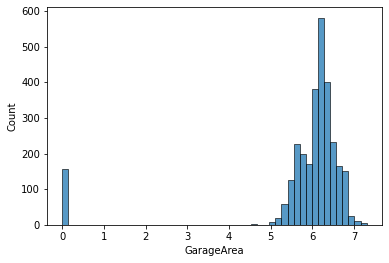

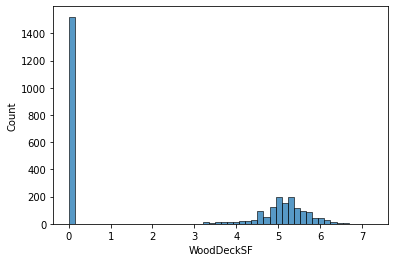

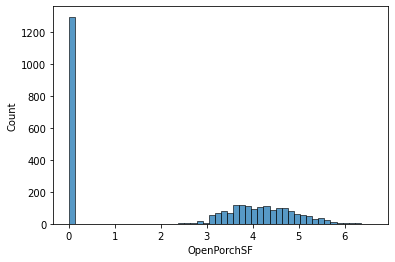

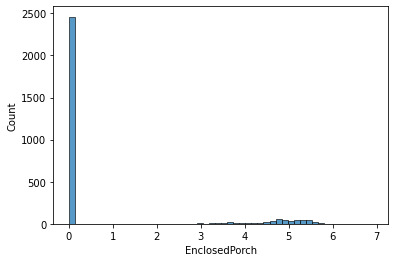

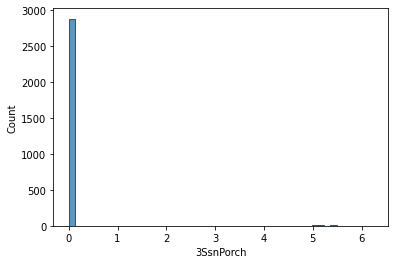

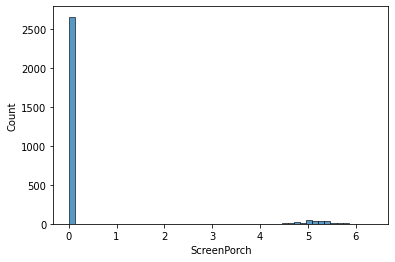

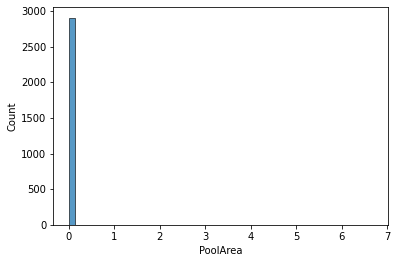

In [18]:
for i in continuous_val:
    if i in list(new_data.columns):
        new_data[i] = np.log(new_data[i]+1)
        sns.histplot(new_data[i], bins=50)
        ax.set_xlabel('')
        ax.set_title('histogram of feature: ' + str(i))
        plt.show()

- GrivArea

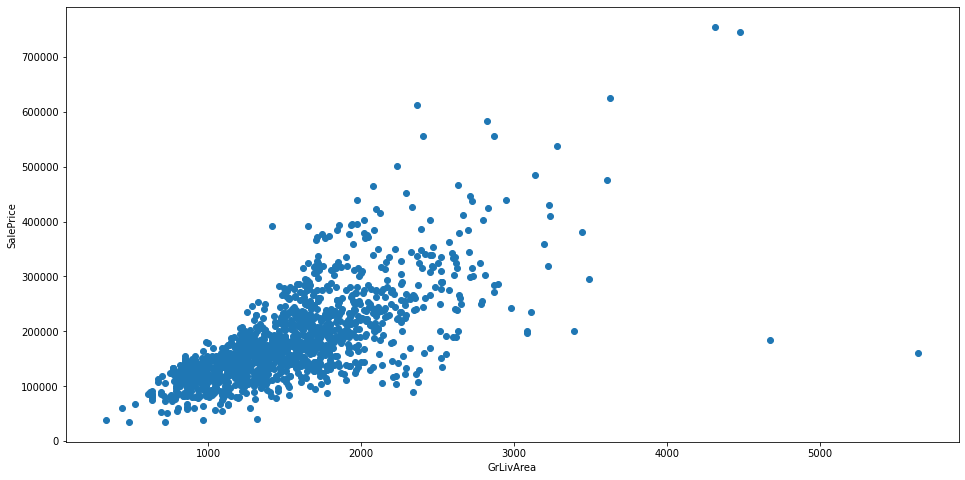

In [19]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data['GrLivArea'], data['SalePrice'])
ax.set_xlabel('GrLivArea')
ax.set_ylabel('SalePrice')
plt.show()

We have several points that are far away, but only two not have the same direction. Maybe these points describe some plot area, so they have big square and cheap.So it's our outliers and we can delete them.-
About two points that are high as we see they are our outliers from target value. But they have the same direction as others, so maybe these points describe some huge house or villa... So we will keep them

In [20]:
data.sort_values(by = 'GrLivArea', ascending = False)[:2]
new_data = new_data.drop(1299)
new_data = new_data.drop(524)

* TotalBsmtSF

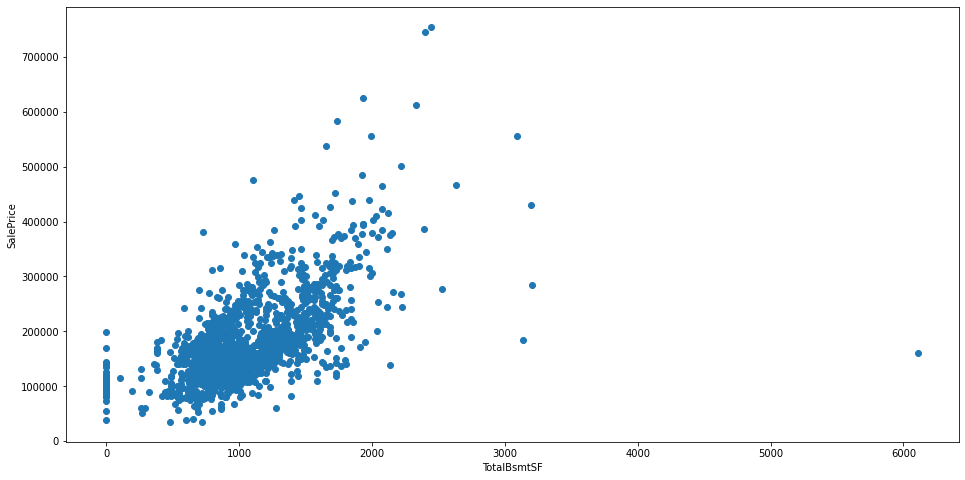

In [21]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(data['TotalBsmtSF'], data['SalePrice'])
ax.set_xlabel('TotalBsmtSF')
ax.set_ylabel('SalePrice')
plt.show()

We have several points that are far away from others, but it seems that they have the same directions, so we can leave them

And what about models?!

Baseline Model

In [22]:
data = new_data.iloc[:len(data)-2,:].join(data[['log_price']])
test = new_data.iloc[len(data):,:]
X = data.iloc[:, :-1]
y = data['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
test_scaler = scaler.fit_transform(test)
X_scaler = scaler.fit_transform(X)
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test)

In [23]:
regression=LinearRegression()
regression.fit(X_train,y_train)
print("Mean absolute error =", round(sm.mean_absolute_error(y_train, regression.predict(X_train)), 2)) 
print("Mean squared error =", round(sm.mean_squared_error(y_train, regression.predict(X_train)), 2))  
print("Median absolute error =", round(sm.median_absolute_error(y_train, regression.predict(X_train)), 2)) 
print("Explain variance score =", round(sm.explained_variance_score(y_train, regression.predict(X_train)), 2)) 
print("R2 score =", sm.r2_score(y_train, regression.predict(X_train)))

Mean absolute error = 0.08
Mean squared error = 0.01
Median absolute error = 0.06
Explain variance score = 0.91
R2 score = 0.9131199861272532


I offer to start with Ridge Reggression. But as we know we need to standardize variables before using Ridge Regression. So now let's do it and look at result.

In [24]:
for i in [1, 0.1, 0.001, 0.005, 0.0005]:
    ridge = Ridge(alpha=i)
    ridge.fit(X_train_scaler, y_train)
    print('alfa parameter is', i)
    print("Mean absolute error =", sm.mean_absolute_error(y_train, ridge.predict(X_train_scaler))) 
    print("Mean squared error =", sm.mean_squared_error(y_train, ridge.predict(X_train_scaler)))
    print("Median absolute error =", sm.median_absolute_error(y_train, ridge.predict(X_train_scaler))) 
    print("Explain variance score =", sm.explained_variance_score(y_train, ridge.predict(X_train_scaler))) 
    print("R2 score =", sm.r2_score(y_train, ridge.predict(X_train_scaler)))

alfa parameter is 1
Mean absolute error = 0.0833707465192898
Mean squared error = 0.01370508850951829
Median absolute error = 0.06024199039869771
Explain variance score = 0.9129437258923461
R2 score = 0.9129437258923461
alfa parameter is 0.1
Mean absolute error = 0.08330375807111239
Mean squared error = 0.013680961048718259
Median absolute error = 0.060446601272142075
Explain variance score = 0.9130969862554199
R2 score = 0.91309698625542
alfa parameter is 0.001
Mean absolute error = 0.08327880771914879
Mean squared error = 0.0136773409430085
Median absolute error = 0.06030438913619118
Explain variance score = 0.9131199815768108
R2 score = 0.9131199815768108
alfa parameter is 0.005
Mean absolute error = 0.08327986914117576
Mean squared error = 0.013677357561437694
Median absolute error = 0.06029592914967985
Explain variance score = 0.9131198760146668
R2 score = 0.9131198760146668
alfa parameter is 0.0005
Mean absolute error = 0.08327867259999552
Mean squared error = 0.01367734040647148

The default value has the best performance. But as we have only a few variables that have large effect on our target values, so now let's try Lasso Regression but also with standardized variables

In [25]:
for i in [1, 0.1, 0.001, 0.005, 0.0005]:
    lasso = Lasso(alpha=i)
    lasso.fit(X_train_scaler, y_train)
    print('alfa parameter is', i)
    print("Mean absolute error =", sm.mean_absolute_error(y_train, lasso.predict(X_train_scaler))) 
    print("Mean squared error =", sm.mean_squared_error(y_train, lasso.predict(X_train_scaler)))  
    print("Median absolute error =", sm.median_absolute_error(y_train, lasso.predict(X_train_scaler))) 
    print("Explain variance score =", sm.explained_variance_score(y_train, lasso.predict(X_train_scaler))) 
    print("R2 score =", sm.r2_score(y_train, lasso.predict(X_train_scaler)))

alfa parameter is 1
Mean absolute error = 0.30648000257705527
Mean squared error = 0.15742792406404332
Median absolute error = 0.2480654104058324
Explain variance score = 2.220446049250313e-16
R2 score = 0.0
alfa parameter is 0.1
Mean absolute error = 0.15319482783237487
Mean squared error = 0.04414161599532091
Median absolute error = 0.1119636412427516
Explain variance score = 0.7196074568234563
R2 score = 0.7196074568234563
alfa parameter is 0.001
Mean absolute error = 0.0835640574836718
Mean squared error = 0.0138255665881394
Median absolute error = 0.0616951110277526
Explain variance score = 0.912178435494614
R2 score = 0.912178435494614
alfa parameter is 0.005
Mean absolute error = 0.0863287620928613
Mean squared error = 0.01471321396631884
Median absolute error = 0.06228800928750555
Explain variance score = 0.9065399988356999
R2 score = 0.9065399988356999
alfa parameter is 0.0005
Mean absolute error = 0.08348797946978133
Mean squared error = 0.013760875039789679
Median absolute e

Not bad, but we see that results almost the same. So now let's try a combination of L1 and L2 regularization

In [26]:
for i in [0.1, 0.001, 0.0005]:
    for j in [.2,.4,.6, 0.8]:
        net = ElasticNet(alpha=i,l1_ratio=j)
        net.fit(X_train_scaler, y_train)
        print('alfa parameter is', i, 'l1_ratio parameter is', j)
        print("Mean absolute error =", sm.mean_absolute_error(y_test, net.predict(X_test_scaler))) 
        print("Mean squared error =", sm.mean_squared_error(y_test, net.predict(X_test_scaler))) 
        print("Median absolute error =", sm.median_absolute_error(y_test, net.predict(X_test_scaler))) 
        print("Explain variance score =", sm.explained_variance_score(y_test, net.predict(X_test_scaler)))
        print("R2 score =", sm.r2_score(y_test, net.predict(X_test_scaler)))

alfa parameter is 0.1 l1_ratio parameter is 0.2
Mean absolute error = 0.10321023190114528
Mean squared error = 0.02062786784195423
Median absolute error = 0.07404160983113073
Explain variance score = 0.8776997094993253
R2 score = 0.8776365460282022
alfa parameter is 0.1 l1_ratio parameter is 0.4
Mean absolute error = 0.11464142308225211
Mean squared error = 0.025917886430881776
Median absolute error = 0.07907373384665561
Explain variance score = 0.8463195905711023
R2 score = 0.8462564270999792
alfa parameter is 0.1 l1_ratio parameter is 0.6
Mean absolute error = 0.12894242611678794
Mean squared error = 0.032595489246063335
Median absolute error = 0.08938680519573605
Explain variance score = 0.8067083931861957
R2 score = 0.8066452297150726
alfa parameter is 0.1 l1_ratio parameter is 0.8
Mean absolute error = 0.14294095196287385
Mean squared error = 0.03930804851219857
Median absolute error = 0.10521396729995391
Explain variance score = 0.7668898359272556
R2 score = 0.7668266724561325
al

We have the best result with Ridge model when alpha = 0.0005. So now let's predict our test data

In [27]:
ridge = Ridge(alpha=0.001)
ridge.fit(X_scaler, y)
print("Mean absolute error =", sm.mean_absolute_error(y, ridge.predict(X_scaler))) 
print("Mean squared error =", sm.mean_squared_error(y, ridge.predict(X_scaler)))
print("Median absolute error =", sm.median_absolute_error(y, ridge.predict(X_scaler))) 
print("Explain variance score =", sm.explained_variance_score(y, ridge.predict(X_scaler))) 
print("R2 score =", sm.r2_score(y, ridge.predict(X_scaler)))

Mean absolute error = 0.08416784606661977
Mean squared error = 0.013849862122345126
Median absolute error = 0.06270849081444574
Explain variance score = 0.913255567948238
R2 score = 0.913255567948238


In [28]:
result = pd.DataFrame({'Id':list(test.index), 'SalePrice': np.e**ridge.predict(test_scaler)})
result.head(10)

,Id,SalePrice
0,1461,120877.749925
1,1462,154838.701629
2,1463,186715.411054
3,1464,202484.227438
4,1465,199541.397365
5,1466,180349.073707
6,1467,191014.466644
7,1468,167380.364724
8,1469,197876.660823
9,1470,110305.705049


In [29]:
result.to_csv("result.csv", index=False)